# Filtering and predicting using the Gaussian Process filter
In this notebook, we will look at filtering noisy data by fitting a Gaussian Process on it.

The Gaussian Process filter, just like the Kalman filter, is a `FilteringModel` in Darts (and not a `ForecastingModel`). `FilteringModel`s can be used to smooth series, or to attempt to infer the "true" data from the data corrupted by noise.

In the case of the Gaussian Process, this is done by making assumptions about the shape of the underlying function on which the true data points lie. These assumptions (e.g. smoothness, periodicity, ...) are encoded in the kernels. 

In this notebook, we'll generate a simple periodic signal and see how the Gaussian Process filter can be used to de-noise it.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import GaussianProcessFilter

from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

## Adding white noise to a sine wave
We create a simple sine wave signal and add Gaussian noise to it.

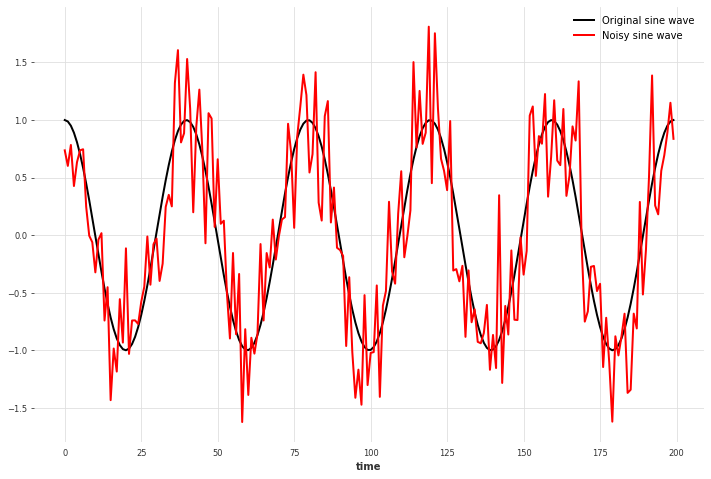

In [12]:
NOISE_DISTANCE = 0.4
SAMPLE_SIZE = 200

# Prepare the sine wave
theta = np.radians(np.linspace(0,360*5,SAMPLE_SIZE))
x = TimeSeries.from_values(np.cos(theta))

# Add white noise 
noise = TimeSeries.from_values(np.random.normal(0, NOISE_DISTANCE, SAMPLE_SIZE))
x_noise = x + noise

plt.figure(figsize=[12,8])
x.plot(label='Original sine wave')
x_noise.plot(color='red', label='Noisy sine wave')
plt.legend()
plt.show()

## Infer the mean of a Gaussian Process using a periodic kernel
Next, we fit a Gaussian Process on the data using the `ExpSineSquared` kernel. This kernel encodes a periodicity assumption, which is appropriate for our data. You can try to uncomment the `kernel = RBF()` line to change the kernel to an `RBF` kernel, which only imposes smoothness of the function. See [The Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) for more information about (Gaussian Process) kernels and how to combine them.

The `GaussianProcessFilter` constructor takes the same arguments as scikit-learn's `GaussianProcessRegressor` on which is relies. The kernels implemented in scikit-learn can be found [here](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes).

Here, we set a relative noise variance of `alpha=0.2` because we know exactly how much noise we added before, but in practice this will have to estimated.

We see that the mean of Gaussian Process lies very close to the original signal. Bear in mind though that real data will rarely be so perfectly periodic and more experimentation with kernels and noise levels will be needed.

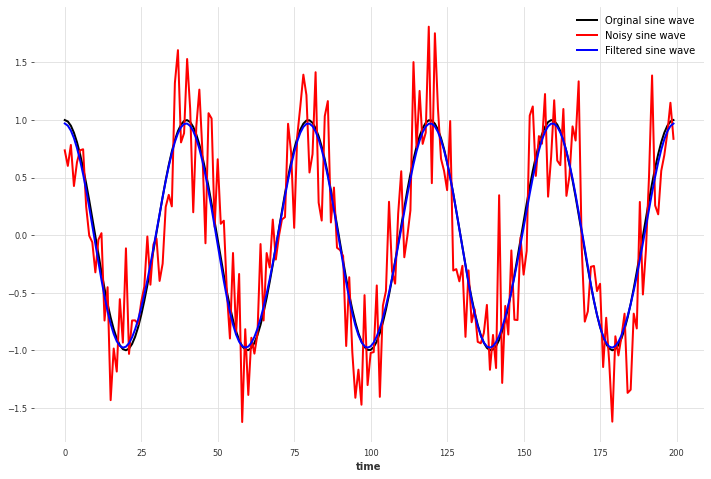

In [13]:
kernel = ExpSineSquared()
# kernel = RBF()

GP = GaussianProcessFilter(kernel=kernel, alpha=0.2, n_restarts_optimizer=100)
filtered_x = GP.filter(x_noise)

plt.figure(figsize=[12,8])
x.plot(color='black', label='Orginal sine wave')
x_noise.plot(color='red', label='Noisy sine wave')
filtered_x.plot(color='blue', label='Filtered sine wave')
plt.legend()

## Sample from a Gaussian Process
The Gaussian Process is a probabilistic model, meaning that the predictions of the model are distributions instead of single values.

Before, we just used the mean of these distributions at the points of interest to plot a curve. Here instead, we will sample from the distributions and plot the 90% confidence interval. From this we can see that the uncertainty about the underlying data is larger around the crests and troughs than elsewhere.

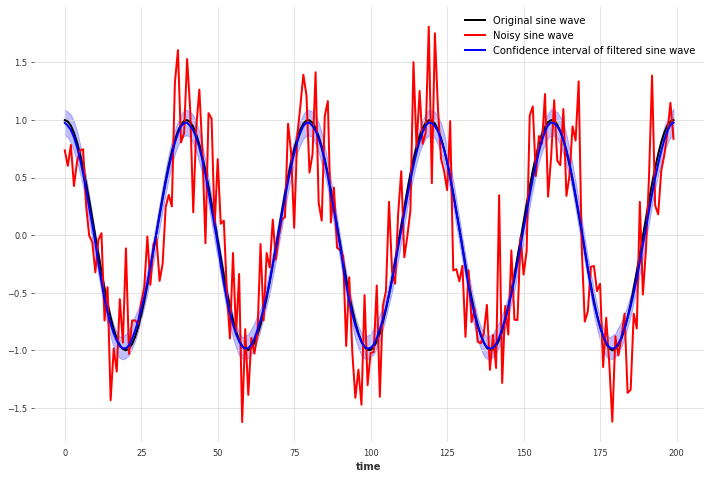

In [18]:
filtered_x_samples = GP.filter(x_noise, num_samples=100)

plt.figure(figsize=[12,8])
x.plot(color='black', label='Original sine wave')
x_noise.plot(color='red', label='Noisy sine wave')
filtered_x_samples.plot(color='blue', label='Confidence interval of filtered sine wave')
plt.legend()

## Sample from a Gaussian Process with missing data points
We can even use the Gaussian Process filter on time series with missing (NaN) data points.

For our periodic signal, the Gaussian Process estimates the missing data very well using the periodic kernel. You can see how this changes and the uncertainty increases when using the RBF kernel instead.

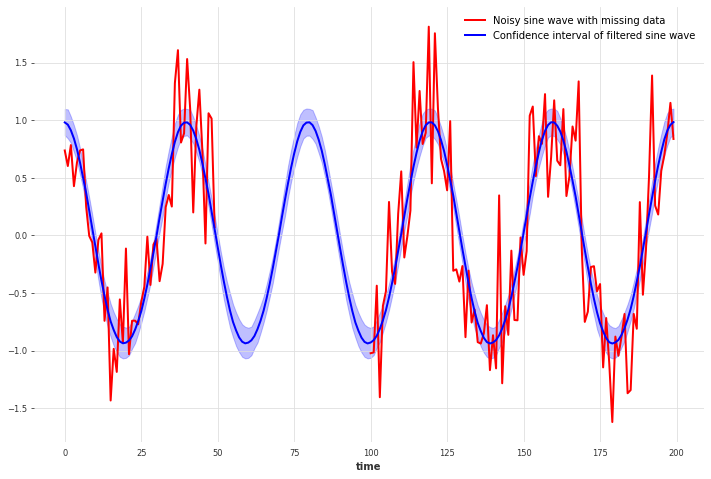

In [81]:
x_missing_arr = x_noise.values()
x_missing_arr[50:100] = np.nan
x_missing = TimeSeries.from_values(x_missing_arr)

kernel = ExpSineSquared()
# kernel = RBF()

GP_missing = GaussianProcessFilter(kernel=kernel, alpha=0.2, n_restarts_optimizer=100)
filtered_x_missing_samples = GP_missing.filter(x_missing, num_samples=100)

plt.figure(figsize=[12,8])
x_missing.plot(color='red', label='Noisy sine wave with missing data')
filtered_x_missing_samples.plot(color='blue', label='Confidence interval of filtered sine wave')
plt.legend()